In [2]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import SpikeTrain, TuningCurve, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

code_id = "0844 - Manifold of Initialization"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

# Segment of Interests
SIG1 = np.array([4, 5, 8, 7, 6, 18, 17, 29, 30, 31, 19, 20, 21, 9, 10, 11, 12, 24])
SIG2 = np.array([23, 22, 34, 33, 32, 44, 45, 46, 47, 48, 60, 59, 58, 57, 56])
SIG3 = np.array([84, 83, 95, 93, 105, 106, 94, 82, 81, 80, 92, 104, 103, 91, 90, 78, 79, 67, 55, 54, 66, 65, 64, 63, 75, 74, 62, 
                 50, 51, 39, 38, 37, 49])
SIG4 = np.array([61, 73, 85, 97, 135, 134, 133, 121, 109, 110, 122, 123, 111, 112, 100])

import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans


def get_neural_traj(trace: dict, is_shuffle=False):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    
    neural_trajs = []
    pos_trajs = []
    route_trajs = []
    lap_trajs = []
    map_trajs = []
    speed_trajs = []

    for i in range(beg_idx.shape[0]):
        if trace['is_perfect'][i] != 1:
            continue
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        if is_shuffle:
            for j in range(Spikes.shape[0]):
                Spikes[j, :] = Spikes[j, np.random.permutation(Spikes.shape[1])]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        neural_traj = spike_train.calc_neural_trajectory(500, 100)
        neural_traj_vec = neural_traj.to_array()
        pos_traj = neural_traj.variable.to_array()
        time_traj = neural_traj.time
        
        neural_trajs.append(neural_traj_vec)
        pos_trajs.append(pos_traj)
        dx, dy = np.ediff1d(trace['correct_pos'][:, 0]), np.ediff1d(trace['correct_pos'][:, 1])
        dt = np.ediff1d(trace['correct_time'])
        speed = np.sqrt(dx**2+dy**2) / dt * 100
        speed = np.convolve(speed, np.ones(3)/3, mode='same')
        idx = _coordinate_recording_time(time_traj.astype(np.float64), trace['correct_time'].astype(np.float64))
        speed_trajs.append(speed[idx])
        route_trajs.append(np.repeat(routes[i], neural_traj_vec.shape[1]).astype(np.int64))
        lap_trajs.append(np.repeat(i, neural_traj_vec.shape[1]).astype(np.int64))
        map_trajs.append(np.repeat(trace['map_cluster'][i], neural_traj_vec.shape[1]))
    
    return np.concatenate(neural_trajs, axis=1), np.concatenate(pos_trajs), np.concatenate(route_trajs), np.concatenate(lap_trajs), np.concatenate(map_trajs), np.concatenate(speed_trajs)

def hex_to_rgba(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-255).
    """
    hex_color = hex_color.lstrip('#')  # Remove '#' if present
    if len(hex_color) == 6:
        r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        a = 255  # Default alpha
    elif len(hex_color) == 8:
        r, g, b, a = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16), int(hex_color[6:8], 16)
    else:
        raise ValueError("Invalid hex color format. Use #RRGGBB or #RRGGBBAA.")
    return r, g, b, a

def hex_to_rgba_normalized(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-1).
    """
    r, g, b, a = hex_to_rgba(hex_color)
    return np.array([r / 255, g / 255, b / 255, a / 255])

DSPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in DSPPalette])
MAPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in ['#333766', '#A4C096']])

from umap.umap_ import UMAP
from matplotlib import cm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN

def compute_centroids(
    reduced_data: np.ndarray,
    route_traj: np.ndarray,
    pos_traj: np.ndarray
):
    idx = np.where(route_traj==0)[0]

    old_traj = spike_nodes_transform(pos_traj[idx]+1, 12)-1
    radii = np.zeros(144)
    centroids = np.zeros((144, 3))
    for i in CP_DSP[0]-1:
        subids = np.where(old_traj == i)[0]
        centroids[i, :] = np.mean(reduced_data[idx[subids], :], axis=0)[:3]
        res = reduced_data[idx[subids], :][:, :3] - centroids[i, :]
        radii[i] = np.percentile(
            np.sqrt(np.sum(res**2, axis=1)), 90
        )
    return centroids, radii
        
def find_min_normalized_distance(points, pos_traj, centroids, radii):
    """
    points   : shape (N, 3)
    centroids: shape (C, 3)
    radii    : shape (C,)  (the 95% range for each centroid)
    
    Returns
    -------
    min_norm_dist : shape (N,)  (the min normalized distance for each point)
    best_centroid : shape (N,)  (index of centroid with min normalized distance)
    """
    old_traj = spike_nodes_transform(pos_traj+1, 12)-1
    # Compute pairwise distance (N, C)
    # diffs[i, j] = points[i] - centroids[j]
    diffs = points - centroids[old_traj, :]  # shape (N, 3)
    sq_dists = np.sum(diffs**2, axis=1)                             # shape (N, )
    dists = np.sqrt(sq_dists)                                       # shape (N, )
    
    # Divide each distance by that centroid's radius
    # radii is (C,), so we broadcast to (N, C)
    norm_dists = dists / radii[old_traj]
    return norm_dists

def counts(traces, index_map, is_shuffle=False):
    count_map = np.where(index_map > 0, 1, 0)
    sums = np.sum(count_map, axis=0)
    idx = np.where(sums == 7)[0]
    
    neural_trajs, pos_trajs, route_trajs, lap_trajs, map_trajs, speed_trajs = [], [], [], [], [], []
    session_trajs = []
    for i in range(len(traces)):
        neural_traj, pos_traj, route_traj, lap_traj, map_traj, speed_traj = get_neural_traj(traces[i], is_shuffle=is_shuffle)
        neural_trajs.append(neural_traj[index_map[i, idx]-1, :])
        pos_trajs.append(pos_traj)
        route_trajs.append(route_traj)
        lap_trajs.append(lap_traj)
        session_trajs.append(np.repeat(i, len(lap_traj)))
        map_trajs.append(map_traj)
        speed_trajs.append(speed_traj)
        
    neural_traj = np.concatenate(neural_trajs, axis=1)
    pos_traj = np.concatenate(pos_trajs)
    route_traj = np.concatenate(route_trajs)
    lap_traj = np.concatenate(lap_trajs)
    session_traj = np.concatenate(session_trajs)
    map_traj = np.concatenate(map_trajs)
    speed_traj = np.concatenate(speed_trajs)
    map_traj[map_traj==2] = 1

    #overlapping_bins = np.concatenate([Father2SonGraph[i] for i in [None, SIG1, SIG2, SIG3, SIG4][sig_type]])-1
    #overlapping_bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1
    #idx = np.where((np.isin(pos_traj, overlapping_bins) == False))[0]
    """
    idx = np.concatenate([
        np.where(
            (np.isin(pos_traj, np.concatenate([Father2SonGraph[j] for j in CP_DSP[i][:6]]))) &
            (np.isin(route_traj, [i]))
        )[0] for i in [1, 2, 3, 4, 5, 6]
    ])
    
    neural_traj = neural_traj[:, idx]
    pos_traj = pos_traj[idx]
    route_traj = route_traj[idx]
    lap_traj = lap_traj[idx]
    session_traj = session_traj[idx]
    map_traj = map_traj[idx]
    speed_traj = speed_traj[idx]
    """
    print(neural_traj.shape, pos_traj.shape, route_traj.shape, lap_traj.shape)

    D = GetDMatrices(1, 48)
    dist_traj = D[pos_traj, 2303]
    dists = (dist_traj // 2).astype(np.int64)

    pca = PCA(n_components=30, random_state=42)
    denoised_data = pca.fit_transform(neural_traj.T)
    model = UMAP(n_components=3)
    reduced_data = model.fit_transform(denoised_data)

    # Use DBSCAN to further denoise
    dbscan = DBSCAN(eps=1, min_samples=50)
    res = dbscan.fit_predict(reduced_data[:, :3])
    idx = np.where(res != -1)[0]
    
    neural_traj = neural_traj[:, idx]
    pos_traj = pos_traj[idx]
    route_traj = route_traj[idx]
    lap_traj = lap_traj[idx]
    session_traj = session_traj[idx]
    map_traj = map_traj[idx]
    speed_traj = speed_traj[idx]
    reduced_data = reduced_data[idx, :]

    centroid, raddi = compute_centroids(
        reduced_data=reduced_data,
        route_traj=route_traj,
        pos_traj=pos_traj
    )
    dist_clusters = find_min_normalized_distance(reduced_data[:, :3], pos_traj, centroid, raddi)
    map_clusters = np.where(dist_clusters <= 1, 0, -1)

    """
    # Manually Label
    for_cluster_idx0 = np.where(
        (route_traj == 0)
    )[0]
    dlap = np.ediff1d(lap_traj)
    beg = np.concatenate([[0], np.where(dlap != 0)[0]+1])
    for_cluster_idx1 = np.concatenate([
        np.arange(beg[i], beg[i]+10)
        for i in range(beg.shape[0])
    ])
    for_cluster_idx = np.concatenate([for_cluster_idx0, for_cluster_idx1])
    labels = np.concatenate([
        np.zeros(for_cluster_idx0.shape[0]),
        np.ones(for_cluster_idx1.shape[0])
    ])
    
    """
    dbscan = DBSCAN(eps=0.4, min_samples=50)
    idx = np.where(map_clusters == -1)[0]
    res = dbscan.fit_predict(reduced_data[idx, :3])
    max_label = np.argmax([np.where(res == i)[0].shape[0] for i in np.unique(res)[1:]])
    print("Second DBSCAN: ", np.unique(res))
    map_clusters[idx[res == max_label]] = 1
    
    # Label Cluster Using 
    svm = SVC(kernel="rbf", random_state=42)
    svm.fit(reduced_data[map_clusters >= 0, :3], map_clusters[map_clusters>=0])
    map_clusters = np.asarray(svm.predict(reduced_data[:, :3])).astype(np.int64)
    dist_clusters = np.asarray(svm.decision_function(reduced_data[:, :3])).astype(np.float64)
    print(f"SVM Final Cluster:", np.unique(map_clusters))
    
    dlap = np.ediff1d(lap_traj)
    beg = np.concatenate([[0], np.where(dlap != 0)[0]+1])
    end = np.concatenate([np.where(dlap != 0)[0]+1, [lap_traj.shape[0]]])
    
    return map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj

def draw(traces, index_map, elev = 50, azim = 160):
    map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj = counts(
        traces, index_map
    )
    PC1, PC2, PC3 = reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2]
    D = GetDMatrices(1, 48)
    dist_traj = D[pos_traj, 2303]
    dists = (dist_traj // 2).astype(np.int64)
    dist_colors = plt.get_cmap("rainbow")((dist_traj - np.min(dist_traj))/(np.max(dist_traj) - np.min(dist_traj)))
    manifold_colors = MAPPaletteRGBA[map_clusters, :]
    
    
    dlap = np.ediff1d(lap_traj)
    beg = np.concatenate([[0], np.where(dlap != 0)[0]+1])
    end = np.concatenate([np.where(dlap != 0)[0]+1, [lap_traj.shape[0]]])
    
    # Each route select 10 laps
    selected_beg, selected_end = [], []
    for route in range(7):
        for day in range(7):
            idx = np.where((route_traj[beg] == route)&(session_traj[beg] == day))[0]
            if idx.shape[0] == 0:
                continue
            
            selected_idx = np.random.choice(idx, min(idx.shape[0], 1), replace = False)
            selected_beg.append(beg[selected_idx])
            selected_end.append(end[selected_idx])
        
    selected_beg, selected_end = np.concatenate(selected_beg), np.concatenate(selected_end)
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), subplot_kw={'projection': '3d'})
    print(f"{beg.shape[0]} Laps total")
    session_colors2 = sns.color_palette("rainbow", 7)
    exclude_idx = []
    for i in np.random.permutation(np.arange(selected_beg.shape[0])):
        beg_idx, end_idx = selected_beg[i], selected_end[i]
        
        axes[0, 0].plot(PC1[beg_idx:end_idx], PC2[beg_idx:end_idx], PC3[beg_idx:end_idx], linewidth=1, color = DSPPalette[route_traj[beg_idx]])
        #axes[2].plot(PC1[beg_idx:end_idx], PC2[beg_idx:end_idx], PC3[beg_idx:end_idx], linewidth=1, color = ['#333766', '#A4C096'][map_clusters[beg_idx]])
        axes[0, 1].scatter( 
            PC1[beg_idx:end_idx], 
            PC2[beg_idx:end_idx], 
            PC3[beg_idx:end_idx],
            color=manifold_colors[beg_idx:end_idx, :],
            s=5,
            linewidth = 0
        )
        axes[1, 0].scatter( 
            PC1[beg_idx:end_idx], 
            PC2[beg_idx:end_idx], 
            PC3[beg_idx:end_idx],
            color=dist_colors[beg_idx:end_idx, :],
            s=5,
            linewidth = 0
        )
    
    axes[1, 1].plot(centroid[CP_DSP[0]-1, 0], centroid[CP_DSP[0]-1, 1], centroid[CP_DSP[0]-1, 2], linewidth=0.5, color='k')
    colors2 = plt.get_cmap("rainbow")(np.linspace(0.9999, 0, CP_DSP[0].shape[0]))
    axes[1, 1].scatter( 
        centroid[CP_DSP[0]-1, 0], centroid[CP_DSP[0]-1, 1], centroid[CP_DSP[0]-1, 2],
        color=colors2,
        s=10,
        alpha=0.8,
        linewidth = 0
    )
        
    axes[0, 0].set_xlabel("UMAP1")
    axes[0, 0].set_ylabel("UMAP2")
    exclude_idx = np.array(exclude_idx)
    axes[0, 0].view_init(elev=elev, azim=azim)
    axes[0, 1].view_init(elev=elev, azim=azim)
    axes[1, 0].view_init(elev=elev, azim=azim)
    axes[1, 1].view_init(elev=elev, azim=azim)
    plt.savefig(join(loc, f"{traces[0]['MiceID']} - [example].png"), dpi=600)
    plt.savefig(join(loc, f"{traces[0]['MiceID']} - [example].svg"), dpi=600)
    plt.show()
    
    fig = plt.figure(figsize=(4, 4))
    ax = Clear_Axes(plt.axes())
    DrawMazeProfile(axes=ax, color='k', linewidth = 0.5)
    x, y = (pos_traj) % 48 + np.random.rand(pos_traj.shape[0])-0.5, pos_traj // 48 + np.random.rand(pos_traj.shape[0])-0.5
    """
    ego_dist_traj = np.zeros_like(dist_traj)
    for i in range(7):
        idx = np.where(route_traj == i)[0]
        ego_dist_traj[idx] = D[pos_traj[idx], SP_DSP[i]-1]
    """
    idx = np.concatenate([np.arange(selected_beg[i], selected_end[i]) for i in np.setdiff1d(np.arange(selected_beg.shape[0]), exclude_idx)])
    #idx = idx[ego_dist_traj[idx] <= 30]
    #ego_colors = plt.get_cmap("rainbow")((ego_dist_traj[idx] - np.min(ego_dist_traj[idx]))/(np.max(ego_dist_traj[idx]) - np.min(ego_dist_traj[idx])))

    ax.scatter(
        x[idx], y[idx], color = dist_colors[idx], 
        s=2, alpha=0.8, linewidth = 0
    )
    ax.invert_yaxis()
    plt.savefig(join(loc, f"{traces[0]['MiceID']} [example] position.png"), dpi=600)
    plt.savefig(join(loc, f"{traces[0]['MiceID']} [example] position.svg"), dpi=600)
    plt.show()


"""
traces = []
mouse = 10227
for i in np.where(f2['MiceID'] == mouse)[0]:
    with open(f2['Trace File'][i], 'rb') as handle:
        trace = pickle.load(handle)
    traces.append(trace)

with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as handle:
    index_map = pickle.load(handle)
    
    if mouse != 10232:
        index_map = index_map[1:, :]
    
    index_map = index_map.astype(np.int64)
#draw(traces, index_map, 33, -29) # 10227 Parameters

map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi = counts(
    traces, index_map
)
"""

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0844 - Manifold of Initialization is already existed!


"\ntraces = []\nmouse = 10227\nfor i in np.where(f2['MiceID'] == mouse)[0]:\n    with open(f2['Trace File'][i], 'rb') as handle:\n        trace = pickle.load(handle)\n    traces.append(trace)\n\nwith open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as handle:\n    index_map = pickle.load(handle)\n    \n    if mouse != 10232:\n        index_map = index_map[1:, :]\n    \n    index_map = index_map.astype(np.int64)\n#draw(traces, index_map, 33, -29) # 10227 Parameters\n\nmap_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi = counts(\n    traces, index_map\n)\n"

In [2]:
if __name__ == '__main__':
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if exists(join(loc, f"{mouse}_shuffle.pkl")):
            with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
                map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj = pickle.load(handle)
        else:
            traces = []
            for i in np.where(f2['MiceID'] == mouse)[0]:
                with open(f2['Trace File'][i], 'rb') as handle:
                    trace = pickle.load(handle)
                traces.append(trace)

            with open(f_CellReg_dsp['cellreg_folder'][1+m], 'rb') as handle:
                index_map = pickle.load(handle)
            
                if mouse != 10232:
                    index_map = index_map[1:, :]
            
            map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj = counts(traces, index_map.astype(np.int64), is_shuffle=True)
            with open(join(loc, f"{mouse}_shuffle.pkl"), 'wb') as f:
                pickle.dump(
                    [map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj],
                    f
                )

(118, 54728) (54728,) (54728,) (54728,)


C:\Users\12454\AppData\Local\Temp\ipykernel_35016\2244739709.py:147: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]


Second DBSCAN:  [-1  0  1]
SVM Final Cluster: [0 1]
(144, 81376) (81376,) (81376,) (81376,)


C:\Users\12454\AppData\Local\Temp\ipykernel_35016\2244739709.py:147: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]


Second DBSCAN:  [-1  0  1]
SVM Final Cluster: [0 1]
(302, 44400) (44400,) (44400,) (44400,)


C:\Users\12454\AppData\Local\Temp\ipykernel_35016\2244739709.py:147: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]


Second DBSCAN:  [-1  0  1  2  3]
SVM Final Cluster: [0 1]
(261, 84802) (84802,) (84802,) (84802,)


C:\Users\12454\AppData\Local\Temp\ipykernel_35016\2244739709.py:147: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]


Second DBSCAN:  [-1  0]
SVM Final Cluster: [0 1]


# Initial Cluster Proportion

(118, 54728) (54728,) (54728,) (54728,)


C:\Users\12454\AppData\Local\Temp\ipykernel_5412\2039391083.py:143: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]


Second DBSCAN:  [-1  0  1  2  3  4  5  6  7  8  9 10]
SVM Final Cluster: [0 1]
(144, 81376) (81376,) (81376,) (81376,)


C:\Users\12454\AppData\Local\Temp\ipykernel_5412\2039391083.py:143: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]


Second DBSCAN:  [-1  0  1  2  3  4  5  6  7  8  9 10]
SVM Final Cluster: [0 1]
(302, 44400) (44400,) (44400,) (44400,)


C:\Users\12454\AppData\Local\Temp\ipykernel_5412\2039391083.py:143: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]


Second DBSCAN:  [-1  0  1  2  3  4  5  6  7  8  9 10 11]
SVM Final Cluster: [0 1]
(261, 84802) (84802,) (84802,) (84802,)


C:\Users\12454\AppData\Local\Temp\ipykernel_5412\2039391083.py:143: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]


Second DBSCAN:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27]
SVM Final Cluster: [0 1]


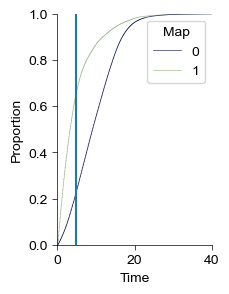

In [3]:
if exists(join(figdata, code_id+" [Init Cluster Proporiton].pkl")) == False:
    ProP = {
        "MiceID": [],
        "Training Day": [],
        "Time": [], 
        "Map": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if exists(join(loc, f"{mouse} .pkl")):
            with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
                map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj = pickle.load(handle)
        else:
            traces = []
            for i in np.where(f2['MiceID'] == mouse)[0]:
                with open(f2['Trace File'][i], 'rb') as handle:
                    trace = pickle.load(handle)
                traces.append(trace)

            with open(f_CellReg_dsp['cellreg_folder'][1+m], 'rb') as handle:
                index_map = pickle.load(handle)
            
                if mouse != 10232:
                    index_map = index_map[1:, :]
            
            map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj = counts(traces, index_map.astype(np.int64))
            with open(join(loc, f"{mouse}.pkl"), 'wb') as f:
                pickle.dump(
                    [map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj],
                    f
                )
        
        time_traj = np.zeros(map_clusters.shape[0])
        for i in range(len(beg)):
            beg_idx, end_idx = beg[i], end[i]
            time_traj[beg_idx:end_idx] = np.linspace(0, (end_idx-beg_idx-1)*100, end_idx-beg_idx)+250
        
        ProP['MiceID'].append(np.repeat(mouse, time_traj.shape[0]))
        ProP['Time'].append(time_traj)
        ProP['Training Day'].append(session_traj)
        ProP['Map'].append(map_clusters)
    
    for k in ProP.keys():
        ProP[k] = np.concatenate(ProP[k])
        
    with open(join(figdata, code_id+' [Init Cluster Proporiton].pkl'), 'wb') as f:
        pickle.dump(ProP, f)
else:
    with open(join(figdata, code_id+' [Init Cluster Proporiton].pkl'), 'rb') as f:
        ProP = pickle.load(f)

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ProP['Time'] /= 1000
sns.ecdfplot(
    x='Time',
    data=ProP,
    hue='Map',
    palette=['#333766', '#A4C096'],
    linewidth=0.5
)
ax.axvline(5)
ax.set_xlim(0, 40)
plt.savefig(join(loc, "Within Manifold Time Distribution.png"), dpi=600)
plt.savefig(join(loc, "Within Manifold Time Distribution.svg"), dpi=600)
plt.show()

# Transition Prob Over Time

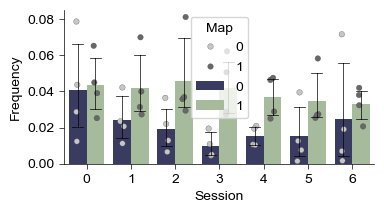

Session 1  Ttest_indResult(statistic=-0.16925352147567274, pvalue=0.8711593012326548)
Session 2  Ttest_indResult(statistic=-1.5278118022889968, pvalue=0.17741937138484445)
Session 3  Ttest_indResult(statistic=-1.9421846273131094, pvalue=0.10013813623903577)
Session 4  Ttest_indResult(statistic=-3.4892476619314325, pvalue=0.012995256830070327)
Session 5  Ttest_indResult(statistic=-3.338524341905987, pvalue=0.01564032301408648)
Session 6  Ttest_indResult(statistic=-1.6610521050610076, pvalue=0.14776862782796454)
Session 7  Ttest_indResult(statistic=-0.5055861428732465, pvalue=0.6311791152047632)

Map 0 - S1 vs. 7: Ttest_indResult(statistic=0.7498180067183242, pvalue=0.4817196264098814)
Map 1 - S1 vs. 7: Ttest_indResult(statistic=1.0890064313742651, pvalue=0.31794621661414774)


In [47]:
def identify_transition(dist_piece: np.ndarray, low_b: float, hig_b: float):
    map_piece = np.where(dist_piece >= 0, 1, 0)
    for i in range(1, len(map_piece)):
        if map_piece[i-1] == 0 and map_piece[i] == 1:
            if dist_piece[i] < hig_b:
                map_piece[i] = 0
        elif map_piece[i-1] == 1 and map_piece[i] == 0:
            if dist_piece[i] > low_b:
                map_piece[i] = 1
    dmap = np.ediff1d(map_piece)
    idx = np.where(dmap != 0)[0]
    
    # State transition should maintain for over 500 ms (5 time bins)
    if len(idx) == 0:
        return idx, np.where(dmap[idx] == -1, 1, 0), map_piece

    delete_idx = []
    jump_idx = -1
    for i in range(0, len(idx)-1):
        if i == jump_idx:
            continue
        
        try:
            if idx[i+1] - idx[i] <= 5:
                delete_idx.append(i)
                delete_idx.append(i+1)
                jump_idx = i+1
        except:
            pass
    
    if len(delete_idx) > 0:
        idx = np.delete(idx, np.array(delete_idx))

    #idx = idx[dmap[idx] == dmap[idx[0]]]
    return idx, np.where(dmap[idx] == -1, 1, 0), map_piece

def transitions(
    dist_clusters: np.ndarray,
    session_clusters: np.ndarray,
    beg: np.ndarray, end:np.ndarray
):
    
    nlap0, nlap1 = np.zeros(7), np.zeros(7)
    nswitch0, nswitch1 = np.zeros(7), np.zeros(7)
    low_b, hig_b = 0, 0
    for i in range(len(beg)):
        dmap, map_type, map_piece = identify_transition(
            dist_clusters[beg[i]:end[i]], low_b, hig_b
        )
        n_session = session_clusters[beg[i]]
        
        if dist_clusters[beg[i]] < 0:
            nlap0[n_session] += np.where(map_piece == 0)[0].shape[0]
        else:
            nlap1[n_session] += np.where(map_piece == 1)[0].shape[0]        
        
        if map_type.shape[0] == 0:
            continue
            
        nswitch0[n_session] += np.where(map_type == 0)[0].shape[0]
        nswitch1[n_session] += np.where(map_type == 1)[0].shape[0]
            
    return nswitch0/nlap0, nswitch1/nlap1

if exists(join(figdata, code_id+"  [switch frequency].pkl")) == False:
    Data = {
        "MiceID": [],
        "Session": [],
        "Frequency": [],
        "Map": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if exists(join(loc, f"{mouse}.pkl")):
            with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
                map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj = pickle.load(handle)
        else:
            traces = []
            for i in np.where(f2['MiceID'] == mouse)[0]:
                with open(f2['Trace File'][i], 'rb') as handle:
                    trace = pickle.load(handle)
                traces.append(trace)

            with open(f_CellReg_dsp['cellreg_folder'][1+m], 'rb') as handle:
                index_map = pickle.load(handle)
            
                if mouse != 10232:
                    index_map = index_map[1:, :]
            
            map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj = counts(traces, index_map.astype(np.int64))
            with open(join(loc, f"{mouse}.pkl"), 'wb') as f:
                pickle.dump(
                    [map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi, neural_traj],
                    f
                )
                
        freq0, freq1 = transitions(dist_clusters, session_traj, beg, end)
        
        Data['MiceID'].append(np.repeat(mouse, 14))
        Data['Frequency'] += [freq0, freq1]
        Data['Session'] += [np.arange(7), np.arange(7)]
        Data['Map'] += [np.repeat(0, 7), np.repeat(1, 7)]
        
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    with open(join(figdata, code_id+' [switch frequency].pkl'), 'wb') as handle:
        pickle.dump(Data, handle)
    
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id+' [switch frequency].xlsx'), index=False)
else:
    with open(join(figdata, code_id+' [switch frequency].pkl'), 'rb') as handle:
        Data = pickle.load(handle)
    
        
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Session',
    y='Frequency',
    data=Data,
    hue='Map',
    dodge=True,
    palette="Grays",
    size = 4,
    linewidth=0.2,
    zorder=2
)
sns.barplot(
    x='Session',
    y='Frequency',
    data=Data,
    hue='Map',
    palette=['#333766', '#A4C096'],
    capsize=0.5,
    linewidth=0.5,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
plt.savefig(join(loc, "Map Transition Probability.png"), dpi=600)
plt.savefig(join(loc, "Map Transition Probability.svg"), dpi=600)
plt.show()

for i in range(7):
    idx0 = np.where((Data['Session'] == i)&(Data['Map'] == 0))[0]
    idx1 = np.where((Data['Session'] == i)&(Data['Map'] == 1))[0]
    print(f"Session {i+1}  {ttest_ind(Data['Frequency'][idx0], Data['Frequency'][idx1])}")
    
print()
idx00 = np.where((Data['Session'] == 0)&(Data['Map'] == 0))[0]
idx60 = np.where((Data['Session'] == 6)&(Data['Map'] == 0))[0]
print(f"Map 0 - S1 vs. 7: {ttest_ind(Data['Frequency'][idx00], Data['Frequency'][idx60])}")
idx01 = np.where((Data['Session'] == 0)&(Data['Map'] == 1))[0]
idx61 = np.where((Data['Session'] == 6)&(Data['Map'] == 1))[0]
print(f"Map 1 - S1 vs. 7: {ttest_ind(Data['Frequency'][idx01], Data['Frequency'][idx61])}")

# Transition Position

C:\Users\12454\AppData\Local\Temp\ipykernel_17940\2539055515.py:160: RuntimeWarning: invalid value encountered in divide
  rate_maps[0, :, m, d] = scipy.stats.binned_statistic(
C:\Users\12454\AppData\Local\Temp\ipykernel_17940\2539055515.py:168: RuntimeWarning: invalid value encountered in divide
  rate_maps[1, :, m, d] = scipy.stats.binned_statistic(


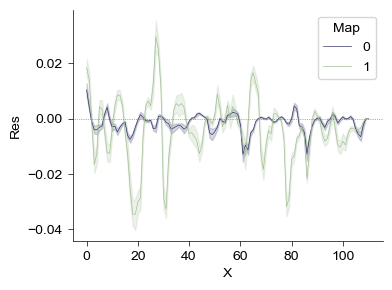

1.2119290154093396


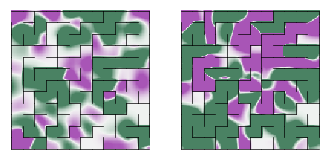

In [22]:
import scipy.stats

def identify_transition_pos(dist_piece: np.ndarray, low_b: float, hig_b: float):
    map_piece = np.where(dist_piece >= 0, 1, 0)
    for i in range(1, len(map_piece)):
        if map_piece[i-1] == 0 and map_piece[i] == 1:
            if dist_piece[i] < hig_b:
                map_piece[i] = 0
        elif map_piece[i-1] == 1 and map_piece[i] == 0:
            if dist_piece[i] > low_b:
                map_piece[i] = 1
        
    dmap = np.ediff1d(map_piece)
    idx = np.where(dmap != 0)[0]
    
    # State transition should maintain for over 500 ms (5 time bins)
    if len(idx) == 0:
        return idx, np.where(dmap[idx] == -1, 1, 0)
    
    delete_idx = []
    jump_idx = -1
    for i in range(0, len(idx)-1):
        if i == jump_idx:
            continue
        
        try:
            if idx[i+1] - idx[i] <= 5:
                delete_idx.append(i)
                delete_idx.append(i+1)
                jump_idx = i+1
        except:
            pass
    
    if len(delete_idx) > 0:
        idx = np.delete(idx, np.array(delete_idx))
    return idx, np.where(dmap[idx] == -1, 1, 0)

def transitions_pos(
    dist_clusters: np.ndarray,
    session_clusters: np.ndarray,
    pos_clusters: np.ndarray,
    beg: np.ndarray, end:np.ndarray
):
    
    pos, mapt, session = [], [], []
    low_b, hig_b = 0, 0
    for i in range(len(beg)):
        dmap, map_type = identify_transition_pos(
            dist_clusters[beg[i]:end[i]], low_b, hig_b
        )
        pos.append(pos_clusters[dmap+beg[i]])
        mapt.append(map_type)
        session.append(session_clusters[dmap+beg[i]])
            
    return np.concatenate(pos), np.concatenate(session), np.concatenate(mapt)

if exists(join(figdata, code_id+" [switch pos].pkl")) == False:
    PData = {
        "MiceID": [],
        "Session": [],
        "Position": [],
        "Map": []
    }
    
    occu_bin = np.zeros((2, 144, 4, 7))
    occu_bin2 = np.zeros((2, 2304, 4, 7))
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):

        if exists(join(loc, f"{mouse}.pkl")):
            with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
                map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi = pickle.load(handle)
        else:
            traces = []
            for i in np.where(f2['MiceID'] == mouse)[0]:
                with open(f2['Trace File'][i], 'rb') as handle:
                    trace = pickle.load(handle)
                traces.append(trace)

            with open(f_CellReg_dsp['cellreg_folder'][1+m], 'rb') as handle:
                index_map = pickle.load(handle)
            
                if mouse != 10232:
                    index_map = index_map[1:, :]
            
            map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi = counts(traces, index_map.astype(np.int64))
            with open(join(loc, f"{mouse}.pkl"), 'wb') as f:
                pickle.dump(
                    [map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi],
                    f
                )
        
        for d in range(7):
            old_bins = spike_nodes_transform(pos_traj+1, 12)
            occu_bin[0, :, m, d] = scipy.stats.binned_statistic(
                old_bins[(dist_clusters <= 0)&(session_traj == d)],
                np.ones(old_bins.shape[0])[(dist_clusters <= 0)&(session_traj == d)],
                bins=144,
                statistic='sum',
                range=[0, 144+1e-8]
            )[0]
            occu_bin[1, :, m, d] = scipy.stats.binned_statistic(
                old_bins[(dist_clusters > 0)&(session_traj == d)],
                np.ones(old_bins.shape[0])[(dist_clusters > 0)&(session_traj == d)],
                bins=144,
                statistic='sum',
                range=[0, 144+1e-8]
            )[0]
        
            occu_bin2[0, :, m, d] = scipy.stats.binned_statistic(
                pos_traj[(dist_clusters <= 0)&(session_traj == d)] + 1,
                np.ones(pos_traj.shape[0])[(dist_clusters <= 0)&(session_traj == d)],
                bins=2304,
                statistic='sum',
                range=[0, 2304+1e-8]
            )[0]
            occu_bin2[1, :, m, d] = scipy.stats.binned_statistic(
                pos_traj[(dist_clusters > 0)&(session_traj == d)] + 1,
                np.ones(pos_traj.shape[0])[(dist_clusters > 0)&(session_traj == d)],
                bins=2304,
                statistic='sum',
                range=[0, 2304+1e-8]
            )[0]
        
        p, s, m = transitions_pos(dist_clusters, session_traj, pos_traj, beg, end)
        
        PData['MiceID'].append(np.repeat(mouse, p.shape[0]))
        PData['Position'] += [p]
        PData['Session'] += [s]
        PData['Map'] += [m]
        
    for k in PData.keys():
        PData[k] = np.concatenate(PData[k])
        
    with open(join(figdata, code_id+' [switch pos].pkl'), 'wb') as handle:
        pickle.dump(PData, handle)
    
    D = pd.DataFrame(PData)
    D.to_excel(join(figdata, code_id+' [switch pos].xlsx'), index=False)
    
    with open(join(figdata, code_id+' [switch pos denominator].pkl'), 'wb') as handle:
        pickle.dump([occu_bin, occu_bin2], handle)
    old_bins = spike_nodes_transform(PData['Position']+1, 12)    
    rate_maps = np.zeros((2, 2304, 4, 7))
    Ms = SmoothMatrix(1, 1)
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        for d in range(7):
            idx0 = np.where(
                (PData['Session'] == d)&
                (PData['MiceID'] == mouse) &
                (PData['Map'] == 0)
            )[0]
            
            idx1 = np.where(
                (PData['Session'] == d)&
                (PData['MiceID'] == mouse) &
                (PData['Map'] == 1)
            )[0]
            
            rate_maps[0, :, m, d] = scipy.stats.binned_statistic(
                PData['Position'][idx0]+1,
                np.ones(idx0.shape[0]),
                bins=2304,
                statistic='sum',
                range=[0, 2304+1e-8]
            )[0] / occu_bin2[0, :, m, d]
            
            rate_maps[1, :, m, d] = scipy.stats.binned_statistic(
                PData['Position'][idx1]+1,
                np.ones(idx1.shape[0]),
                bins=2304,
                statistic='sum',
                range=[0, 2304+1e-8]
            )[0] / occu_bin2[1, :, m, d]
            
            rate_maps[np.where((np.isnan(rate_maps))|(np.isinf(rate_maps)))] = 0
            rate_maps[:, :, m, d] = rate_maps[:, :, m, d] @ Ms.T
    
    with open(join(figdata, code_id+' [switch pos ratemap].pkl'), 'wb') as handle:
        pickle.dump(rate_maps, handle)
    
    Res = {
        "MiceID": [],
        "Session": [],
        "X": [],
        "Res": [],
        "Map": []
    }
    DM = GetDMatrices(1, 48) 
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):

        for d in range(1, 7):
            Res['MiceID'].append(np.repeat(mouse, 2304))
            Res['Session'].append(np.repeat(d, 2304))
            Res['X'].append(DM[:, 0]/np.max(DM) * 880)
            Res['Map'].append(np.repeat(0, 2304))
            Res['Res'].append(rate_maps[0, :, m, d] - rate_maps[0, :, m, 0])
            
            Res['MiceID'].append(np.repeat(mouse, 2304))
            Res['Session'].append(np.repeat(d, 2304))
            Res['X'].append(DM[:, 0]/np.max(DM) * 880)
            Res['Map'].append(np.repeat(1, 2304))
            Res['Res'].append(rate_maps[1, :, m, d] - rate_maps[1, :, m, 0])
    
    for k in Res.keys():
        Res[k] = np.concatenate(Res[k])
    with open(join(figdata, code_id+' [switch pos ratemap stats].pkl'), 'wb') as f:
        pickle.dump(Res, f)

else:
    with open(join(figdata, code_id+' [switch pos].pkl'), 'rb') as handle:
        PData = pickle.load(handle)
        
    with open(join(figdata, code_id+' [switch pos denominator].pkl'), 'rb') as handle:
        occu_bin, occu_bin2 = pickle.load(handle)
    
    with open(join(figdata, code_id+' [switch pos ratemap].pkl'), 'rb') as handle:
        rate_maps = pickle.load(handle)
        
    with open(join(figdata, code_id+' [switch pos ratemap stats].pkl'), 'rb') as handle:
        Res = pickle.load(handle)


Res['X'] = Res['X']//8
DM = GetDMatrices(1, 48)
SP_DSP[1]

fig = plt.figure(figsize=(4,3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='X',
    y='Res',
    data=Res,
    hue='Map',
    ax=ax,
    palette=['#333766', '#A4C096'],
    linewidth = 0.5
)
ax.axhline(0, ls=':', linewidth=0.5)
plt.show()

A = rate_maps[0, :, :, :] - rate_maps[0, :, :, :1]
sumres0 = np.sum(A, axis=1)
sumres0 = np.sum(sumres0, axis=1)

B = rate_maps[1, :, :, :] - rate_maps[1, :, :, :1]
sumres1 = np.nansum(B, axis=1)
sumres1 = np.nansum(sumres1, axis=1)
vmax = max(np.nanmax(np.abs(sumres0)), np.nanmax(np.abs(sumres1)))
print(vmax)
fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(4,2))
ax1, ax2 = Clear_Axes(axes[0]), Clear_Axes(axes[1])
DrawMazeProfile(axes=ax1, color='k', linewidth=0.5)
ax1.imshow(sumres0.reshape(48, 48), vmax=0.05, vmin=-0.05, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True))
ax1.invert_yaxis()
DrawMazeProfile(axes=ax2, color='k', linewidth=0.5)
ax2.imshow(sumres1.reshape(48, 48), vmax=0.05, vmin=-0.05, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True))
ax2.invert_yaxis()
plt.show()

# Transition Speed

(3255,) (265283,)


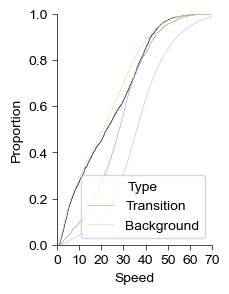

528.9375551560918


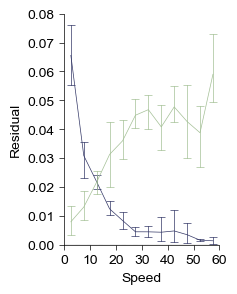

Map 0: F_onewayResult(statistic=41.89982202904773, pvalue=1.456360395721396e-14)
Map 1: F_onewayResult(statistic=9.92389830307467, pvalue=7.23116302329204e-07)


In [17]:
import scipy.stats

DM = GetDMatrices(1, 48)

def identify_transition_pos(dist_piece: np.ndarray, low_b: float, hig_b: float):
    map_piece = np.where(dist_piece >= 0, 1, 0)
    for i in range(1, len(map_piece)):
        if map_piece[i-1] == 0 and map_piece[i] == 1:
            if dist_piece[i] < hig_b:
                map_piece[i] = 0
        elif map_piece[i-1] == 1 and map_piece[i] == 0:
            if dist_piece[i] > low_b:
                map_piece[i] = 1
    dmap = np.ediff1d(map_piece)
    idx = np.where(dmap != 0)[0]
    
    # State transition should maintain for over 500 ms (5 time bins)
    if len(idx) == 0:
        return idx, np.where(dmap[idx] == -1, 1, 0)
    
    delete_idx = []
    jump_idx = -1
    for i in range(0, len(idx)):
        if i == jump_idx:
            continue
        
        try:
            if idx[i+1] - idx[i] <= 5:
                delete_idx.append(i)
                delete_idx.append(i+1)
                jump_idx = i+1
        except:
            pass
    
    if len(delete_idx) > 0:
        idx = np.delete(idx, np.array(delete_idx))
    return idx, np.where(dmap[idx] == -1, 1, 0)

def transitions_speed(
    dist_clusters: np.ndarray,
    session_clusters: np.ndarray,
    speed_clusters: np.ndarray,
    beg: np.ndarray, end:np.ndarray
):
    
    speed, mapt, session = [], [], []
    low_b, hig_b = 0, 0
    for i in range(len(beg)):
        dmap, map_type = identify_transition_pos(
            dist_clusters[beg[i]:end[i]], low_b, hig_b
        )
        speed.append(speed_clusters[dmap+beg[i]])
        mapt.append(map_type)
        session.append(session_clusters[dmap+beg[i]])
            
    return np.concatenate(speed), np.concatenate(session), np.concatenate(mapt)
    
if exists(join(figdata, code_id+" [switch speed].pkl")) == False:
    SData = {
        "MiceID": [],
        "Session": [],
        "Speed": [],
        "Map": []
    }
    
    BGSData = {
        "MiceID": [],
        "Session": [],
        "Speed": [],
        "Map": []
    }
    
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if exists(join(loc, f"{mouse}.pkl")):
            with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
                map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi = pickle.load(handle)
        else:
            traces = []
            for i in np.where(f2['MiceID'] == mouse)[0]:
                with open(f2['Trace File'][i], 'rb') as handle:
                    trace = pickle.load(handle)
                traces.append(trace)

            with open(f_CellReg_dsp['cellreg_folder'][1+m], 'rb') as handle:
                index_map = pickle.load(handle)
            
                if mouse != 10232:
                    index_map = index_map[1:, :]
            
            map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi = counts(traces, index_map.astype(np.int64))
            with open(join(loc, f"{mouse}.pkl"), 'wb') as f:
                pickle.dump(
                    [map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end, reduced_data, centroid, raddi],
                    f
                )
                
        sp, s, mp = transitions_speed(dist_clusters, session_traj, speed_traj, beg, end)
        
        SData['MiceID'].append(np.repeat(mouse, s.shape[0]))
        SData['Speed'].append(sp)
        SData['Session'].append(s)
        SData['Map'].append(mp)
        
        BGSData['MiceID'].append(np.repeat(mouse, speed_traj.shape[0]))
        BGSData['Speed'].append(speed_traj)
        BGSData['Session'].append(session_traj)
        BGSData['Map'] += [np.where(dist_clusters >= 0, 1, 0)]
        
    for k in SData.keys():
        SData[k] = np.concatenate(SData[k])
        BGSData[k] = np.concatenate(BGSData[k])
        
    with open(join(figdata, code_id+' [switch speed].pkl'), 'wb') as handle:
        pickle.dump((SData, BGSData), handle)
    
    D = pd.DataFrame(SData)
    D.to_excel(join(figdata, code_id+' [switch speed].xlsx'), index=False)
    SHData = {
        "Speed": [],
        "Residual": [],
        "MiceID": [],
        "Map": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        x0 = np.histogram(
            SData['Speed'][(SData['MiceID'] == mouse)&(SData['Map'] == 0)],
            range=(0, 60), bins=12
        )[0]
        x1 = np.histogram(
            SData['Speed'][(SData['MiceID'] == mouse)&(SData['Map'] == 1)],
            range=(0, 60), bins=12
        )[0]
        
        y0 = np.histogram(
            BGSData['Speed'][(BGSData['MiceID'] == mouse)&(BGSData['Map'] == 0)],
            range=(0, 60), bins=12
        )[0]
        y1 = np.histogram(
            BGSData['Speed'][(BGSData['MiceID'] == mouse)&(BGSData['Map'] == 1)],
            range=(0, 60), bins=12
        )[0]
        
        SHData['MiceID'].append(np.repeat(mouse, 12))
        SHData['Residual'].append(x0/y0)
        SHData['Map'].append(np.repeat(0, 12))
        SHData['Speed'].append(np.linspace(2.5, 57.5, 12))
        
        SHData['MiceID'].append(np.repeat(mouse, 12))
        SHData['Residual'].append(x1/y1)
        SHData['Map'].append(np.repeat(1, 12))
        SHData['Speed'].append(np.linspace(2.5, 57.5, 12))
        
    for k in SHData.keys():
        SHData[k] = np.concatenate(SHData[k])
        
    with open(join(figdata, code_id+' [switch speed hist].pkl'), 'wb') as f:
        pickle.dump(SHData, f)    
        
else:
    with open(join(figdata, code_id+' [switch speed].pkl'), 'rb') as handle:
        SData, BGSData = pickle.load(handle)

    with open(join(figdata, code_id+' [switch speed hist].pkl'), 'rb') as handle:
        SHData = pickle.load(handle)

  
print(SData['Speed'].shape, BGSData['Speed'].shape)
SData['Speed'] = SData['Speed']

WholeData = {}
for k in SData.keys():
    WholeData[k] = np.concatenate([SData[k], BGSData[k]])
    
WholeData['Type'] = np.concatenate([np.repeat("Transition", SData['Speed'].shape[0]), np.repeat("Background", BGSData['Speed'].shape[0])])

fig = plt.figure(figsize=(2, 3))
colors = [sns.color_palette("Purples", 2)[0], sns.color_palette("Purples", 2)[0]]
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData0 = SubDict(WholeData, WholeData.keys(), np.where(WholeData['Map'] == 0)[0])
sns.ecdfplot(
    data=SubData0,
    x='Speed',
    hue="Type",
    ax=ax,
    palette=['#333766', colors[0]],
    linewidth=0.5
)
SubData1 = SubDict(WholeData, WholeData.keys(), np.where(WholeData['Map'] == 1)[0])
sns.ecdfplot(
    data=SubData1,
    x='Speed',
    hue="Type",
    palette=['#A4C096', ],
    ax=ax,
    linewidth=0.5
)
ax.set_xlim(0, 70)
ax.set_xticks(np.linspace(0, 70, 8))
plt.savefig(join(loc, "Transition Speed [Map all].png"), dpi=600)
plt.savefig(join(loc, "Transition Speed [Map all].svg"), dpi=600)
plt.show()
print(np.max(DM))

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Speed',
    y='Residual',
    data=SHData,
    hue='Map',
    linewidth=0.5,
    err_kws={'linewidth':0.5, 'capsize': 3, 'capthick': 0.5},
    palette=['#333766', '#A4C096'],
    err_style='bars',
    legend=False
)
ax.axhline(0, ls=':', color='k', linewidth=0.25)
ax.set_xlim(0, 60)
ax.set_xticks(np.linspace(0, 60, 7))
ax.set_ylim(0, 0.08)
ax.set_yticks(np.linspace(0, 0.08, 9))
plt.savefig(join(loc, "Transition Speed Residual.png"), dpi=600)
plt.savefig(join(loc, "Transition Speed Residual.svg"), dpi=600)
plt.show()

print(f"Map 0: {f_oneway(*[SHData['Residual'][np.where((SHData['Speed'] == x)&(SHData['Map'] == 0)&(np.isnan(SHData['Residual']) == False))[0]] for x in np.linspace(2.5, 47.5, 10)])}")
print(f"Map 1: {f_oneway(*[SHData['Residual'][np.where((SHData['Speed'] == x)&(SHData['Map'] == 1)&(np.isnan(SHData['Residual']) == False))[0]] for x in np.linspace(2.5, 47.5, 10)])}")

# Example Laps with Cross Manifold Transitions

session 1, Map 1, Route 7, Lap 21 (59)


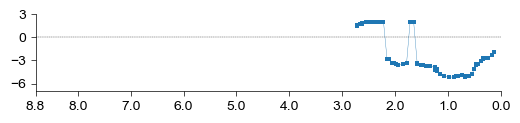

session 2, Map 1, Route 6, Lap 39 (66)


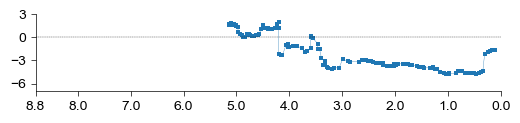

session 3, Map 1, Route 6, Lap 75 (65)


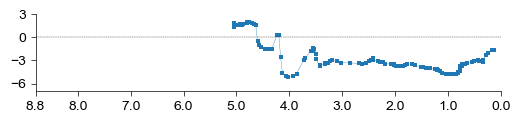

session 4, Map 1, Route 2, Lap 95 (15)


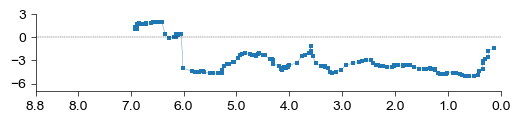

session 4, Map 1, Route 3, Lap 98 (22)


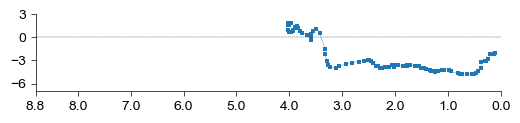

session 4, Map 1, Route 3, Lap 100 (24)


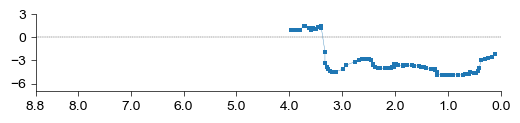

session 4, Map 1, Route 4, Lap 104 (34)


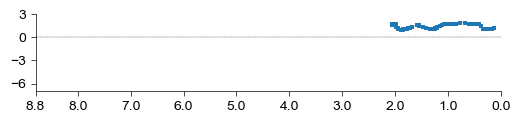

session 4, Map 1, Route 3, Lap 102 (28)


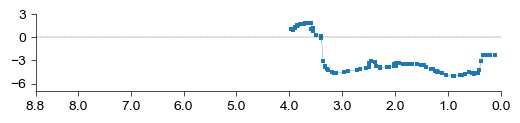

In [12]:
D = GetDMatrices(1, 48)
scale = 888/np.max(D)

for i in np.array([21, 39, 75, 95, 98, 100, 104, 102]):
    plt.figure(figsize=(6,1))
    print(f"session {session_traj[beg[i]]+1}, Map {map_clusters[beg[i]]}, Route {route_traj[beg[i]]+1}, Lap {i} ({lap_traj[beg[i]]+1})")
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    x = dists[beg[i]:end[i]].astype(np.float64)*scale/100*2
    ax.plot(x, dist_clusters[beg[i]:end[i]], marker='s', markeredgewidth=0, markersize=3, linewidth=0.25)
    ax.axhline(0, ls='--', c='k', linewidth=0.25)
    #ax.fill_between([0, 62], np.min(dist_clusters)*0.1, np.max(dist_clusters)*0.1, color = 'gray', alpha=0.2, edgecolor=None)
    #ax.scatter(dists[beg[i]:end[i]], np.repeat(np.max(dist_clusters)+0.4, end[i]-beg[i]), c=dist_colors[beg[i]:end[i]], 
    #    s=3, linewidth = 0)
    ax.set_ylim(-7, 3)
    ax.set_xlim(8.8, 0)
    ax.set_yticks([-6, -3, 0, 3])
    ax.set_xticks([8.8, 8, 7, 6, 5, 4, 3, 2, 1, 0])
    plt.savefig(join(loc, f"Example Map Transition [session {session_traj[beg[i]]+1}-Route {route_traj[beg[i]]}-Lap {i}].png"), dpi=600)
    plt.savefig(join(loc, f"Example Map Transition [session {session_traj[beg[i]]+1}-Route {route_traj[beg[i]]}-Lap {i}].svg"), dpi=600)
    plt.show()
    """
    plt.figure(figsize=(3, 3))
    print(f"session {session_traj[beg[i]]+1}, Map {map_clusters[beg[i]]}, Route {route_traj[beg[i]]+1}, Lap {i} ({lap_traj[beg[i]]+1})")
    ax = Clear_Axes(plt.axes())
    DrawMazeProfile(axes=ax, color='k', linewidth=0.3)
    x, y = pos_traj[beg[i]:end[i]]%48, pos_traj[beg[i]:end[i]]//48
    ax.plot(x, y, markeredgewidth=0, markersize=4, linewidth=0.25)
    ax.plot(x[dist_clusters[beg[i]:end[i]] <= 0], 
            y[dist_clusters[beg[i]:end[i]] <= 0], 
            's', markeredgewidth=0, markersize=4, linewidth=0.25, color = '#333766') #['#333766', '#A4C096']
    ax.plot(x[dist_clusters[beg[i]:end[i]] >= 0], 
            y[dist_clusters[beg[i]:end[i]] >= 0], 
            's', markeredgewidth=0, markersize=4, linewidth=0.25, color = '#A4C096')
    ax.set_aspect("equal")
    ax.invert_yaxis()
    #plt.savefig(join(loc, f"Example Map Transition [session {session_traj[beg[i]]+1}-Route {route_traj[beg[i]]}-Lap {i}] Maze.png"), dpi=600)
    #plt.savefig(join(loc, f"Example Map Transition [session {session_traj[beg[i]]+1}-Route {route_traj[beg[i]]}-Lap {i}] Maze.svg"), dpi=600)
    plt.show()
    """

# Plot Illustration

In [2]:
traces = []
mouse = 10227
for i in np.where(f2['MiceID'] == mouse)[0]:
    with open(f2['Trace File'][i], 'rb') as handle:
        trace = pickle.load(handle)
    traces.append(trace)

with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as handle:
    index_map = pickle.load(handle)
    
    if mouse != 10232:
        index_map = index_map[1:, :]
    
    index_map = index_map.astype(np.int64)

if __name__ == '__main__':
    count_map = np.where(index_map > 0, 1, 0)
    sums = np.sum(count_map, axis=0)
    idx = np.where(sums == 7)[0]
    
    neural_trajs, pos_trajs, route_trajs, lap_trajs, map_trajs, speed_trajs = [], [], [], [], [], []
    session_trajs = []
    for i in range(len(traces)):
        neural_traj, pos_traj, route_traj, lap_traj, map_traj, speed_traj = get_neural_traj(traces[i])
        neural_trajs.append(neural_traj[index_map[i, idx]-1, :])
        pos_trajs.append(pos_traj)
        route_trajs.append(route_traj)
        lap_trajs.append(lap_traj)
        session_trajs.append(np.repeat(i, len(lap_traj)))
        map_trajs.append(map_traj)
        speed_trajs.append(speed_traj)
        
    neural_traj = np.concatenate(neural_trajs, axis=1)
    pos_traj = np.concatenate(pos_trajs)
    route_traj = np.concatenate(route_trajs)
    lap_traj = np.concatenate(lap_trajs)
    session_traj = np.concatenate(session_trajs)
    map_traj = np.concatenate(map_trajs)
    speed_traj = np.concatenate(speed_trajs)
    map_traj[map_traj==2] = 1

    #overlapping_bins = np.concatenate([Father2SonGraph[i] for i in [None, SIG1, SIG2, SIG3, SIG4][sig_type]])-1
    #overlapping_bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1
    #idx = np.where((np.isin(pos_traj, overlapping_bins) == False))[0]
    """
    idx = np.concatenate([
        np.where(
            (np.isin(pos_traj, np.concatenate([Father2SonGraph[j] for j in CP_DSP[i][:6]]))) &
            (np.isin(route_traj, [i]))
        )[0] for i in [1, 2, 3, 4, 5, 6]
    ])
    
    neural_traj = neural_traj[:, idx]
    pos_traj = pos_traj[idx]
    route_traj = route_traj[idx]
    lap_traj = lap_traj[idx]
    session_traj = session_traj[idx]
    map_traj = map_traj[idx]
    speed_traj = speed_traj[idx]
    """
    print(neural_traj.shape, pos_traj.shape, route_traj.shape, lap_traj.shape)

    D = GetDMatrices(1, 48)
    dist_traj = D[pos_traj, 2303]
    dists = (dist_traj // 2).astype(np.int64)

    pca = PCA(n_components=30, random_state=42)
    denoised_data = pca.fit_transform(neural_traj.T)
    model = UMAP(n_components=3)
    reduced_data = model.fit_transform(denoised_data)

    # Use DBSCAN to further denoise
    dbscan = DBSCAN(eps=1, min_samples=50)
    res = dbscan.fit_predict(reduced_data[:, :3])
    idx = np.where(res != -1)[0]
    
    neural_traj = neural_traj[:, idx]
    pos_traj = pos_traj[idx]
    route_traj = route_traj[idx]
    lap_traj = lap_traj[idx]
    session_traj = session_traj[idx]
    map_traj = map_traj[idx]
    speed_traj = speed_traj[idx]
    reduced_data = reduced_data[idx, :]

    centroid, raddi = compute_centroids(
        reduced_data=reduced_data,
        route_traj=route_traj,
        pos_traj=pos_traj
    )
    dist_clusters = find_min_normalized_distance(reduced_data[:, :3], pos_traj, centroid, raddi)
    map_clusters = np.where(dist_clusters <= 1, 0, -1)
    rough_idx = np.where(map_clusters == 0)[0]

    """
    # Manually Label
    for_cluster_idx0 = np.where(
        (route_traj == 0)
    )[0]
    dlap = np.ediff1d(lap_traj)
    beg = np.concatenate([[0], np.where(dlap != 0)[0]+1])
    for_cluster_idx1 = np.concatenate([
        np.arange(beg[i], beg[i]+10)
        for i in range(beg.shape[0])
    ])
    for_cluster_idx = np.concatenate([for_cluster_idx0, for_cluster_idx1])
    labels = np.concatenate([
        np.zeros(for_cluster_idx0.shape[0]),
        np.ones(for_cluster_idx1.shape[0])
    ])
    
    """
    dbscan = DBSCAN(eps=0.4, min_samples=50)
    idx = np.where(map_clusters == -1)[0]
    res = dbscan.fit_predict(reduced_data[idx, :][:, :3])
    max_label = np.argmax([np.where(res == i)[0].shape[0] for i in np.unique(res)[1:]])
    print("Second DBSCAN: ", np.unique(res))
    map_clusters[idx[res == max_label]] = 1
    
    # Cluster 2 Methods
    res_data = reduced_data[idx, :3]
    
    # Label Cluster Using 
    svm = SVC(kernel="rbf", random_state=42)
    svm.fit(reduced_data[map_clusters >= 0, :3], map_clusters[map_clusters>=0])
    map_clusters = np.asarray(svm.predict(reduced_data[:, :3])).astype(np.int64)
    dist_clusters = np.asarray(svm.decision_function(reduced_data[:, :3])).astype(np.float64)
    print(f"SVM Final Cluster:", np.unique(map_clusters))
    
    dlap = np.ediff1d(lap_traj)
    beg = np.concatenate([[0], np.where(dlap != 0)[0]+1])
    end = np.concatenate([np.where(dlap != 0)[0]+1, [lap_traj.shape[0]]])

(302, 44400) (44400,) (44400,) (44400,)


C:\Users\12454\AppData\Local\Temp\ipykernel_25812\2125508192.py:143: RuntimeWarning: divide by zero encountered in divide
  norm_dists = dists / radii[old_traj]


Second DBSCAN:  [-1  0  1  2  3  4  5  6  7  8  9 10]
SVM Final Cluster: [0 1]


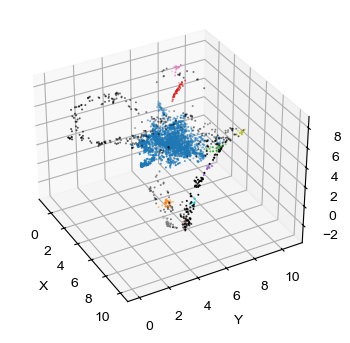

'\ncolors2 = plt.get_cmap("rainbow")(np.linspace(0, 0.9999, CP_DSP[0].shape[0]))\nfor i in np.random.permutation(np.arange(selected_beg.shape[0])):\n    beg_idx, end_idx = selected_beg[i], selected_end[i]\n    \n    shared_idx = np.intersect1d(np.arange(beg_idx, end_idx), rough_idx)\n    ax.scatter( \n            reduced_data[shared_idx, :][:, 0], \n            reduced_data[shared_idx, :][:, 1], \n            reduced_data[shared_idx, :][:, 2], \n            color=dist_colors[shared_idx, :],\n            s=5,\n            linewidth = 0\n    )\nax.view_init(elev= 33, azim=-29)\nplt.savefig(join(loc, "Visualize Method [Step 2].png"), dpi=600)\nplt.savefig(join(loc, "Visualize Method [Step 2].svg"), dpi=600)\nplt.show()\n'

In [4]:
selected_beg, selected_end = [], []
for route in range(7):
    for day in range(7):
        idx = np.where((route_traj[beg] == route)&(session_traj[beg] == day))[0]
        if idx.shape[0] == 0:
            continue
            
        selected_idx = np.random.choice(idx, min(idx.shape[0], 1), replace = False)
        selected_beg.append(beg[selected_idx])
        selected_end.append(end[selected_idx])

selected_beg, selected_end = np.concatenate(selected_beg), np.concatenate(selected_end)
dist_colors = plt.get_cmap("rainbow")((dist_traj - np.min(dist_traj))/(np.max(dist_traj) - np.min(dist_traj)))
    

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
unique_labels = np.unique(res)

idx = np.random.permutation(np.arange(res_data.shape[0]))[:3000]
res_data2 = res_data[idx, :]
res2 =res[idx]
for label in unique_labels:
    mask = (res2 == label)
    if label == -1:
        # Plot outliers in black
        ax.scatter(
            res_data2[mask, 0],
            res_data2[mask, 1],
            res_data2[mask, 2],
            c='k',
            marker='o',
            s=2,
            linewidth=0,
            label='Noise'
        )
    else:
        ax.scatter(
            res_data2[mask, 0],
            res_data2[mask, 1],
            res_data2[mask, 2],
            marker='o',
            s=2,
            linewidth=0,
            label=f'Cluster {label}'
        )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev= 33, azim=-29)
plt.savefig(join(loc, "Visualize Method [Step 3].png"), dpi=600)
plt.savefig(join(loc, "Visualize Method [Step 3].svg"), dpi=600)
plt.show()
"""
colors2 = plt.get_cmap("rainbow")(np.linspace(0, 0.9999, CP_DSP[0].shape[0]))
for i in np.random.permutation(np.arange(selected_beg.shape[0])):
    beg_idx, end_idx = selected_beg[i], selected_end[i]
    
    shared_idx = np.intersect1d(np.arange(beg_idx, end_idx), rough_idx)
    ax.scatter( 
            reduced_data[shared_idx, :][:, 0], 
            reduced_data[shared_idx, :][:, 1], 
            reduced_data[shared_idx, :][:, 2], 
            color=dist_colors[shared_idx, :],
            s=5,
            linewidth = 0
    )
ax.view_init(elev= 33, azim=-29)
plt.savefig(join(loc, "Visualize Method [Step 2].png"), dpi=600)
plt.savefig(join(loc, "Visualize Method [Step 2].svg"), dpi=600)
plt.show()
"""

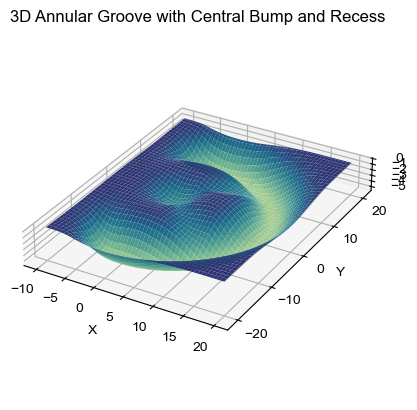

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

def sigmoid(x, k=1):
    return 1 / (1 + np.exp(-k*(x+6)))

# Define the Gaussian function
def gaussian(x):
    return np.exp(-x**2 / 2/8) / np.sqrt(2*np.pi)

# Define the main function to generate the structure
def func(x, y):
    l = np.sqrt(x**2 + y**2)  # Radial distance
    theta = np.arctan2(y, x)-np.pi
    return (-gaussian(l + 15)*20 - gaussian(l)*10 - gaussian(l - 15)*20) * sigmoid(x)*0.7 # The sum of Gaussians

# Create a meshgrid for the surface
x, y = np.meshgrid(np.linspace(-10, 20, 4001), np.linspace(-20, 20, 4001))
z = func(x, y)

"""
# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap=sns.color_palette("crest", as_cmap=True))

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect("equal")
ax.set_title('3D Annular Groove with Central Bump and Recess')
plt.savefig(join(loc, "Illustration Figure.png"), dpi=600)
plt.savefig(join(loc, "Illustration Figure.svg"), dpi=600)
# Show plot
plt.show()


def func2(x, y):
    l = np.sqrt(x**2 + y**2)  # Radial distance
    theta = np.arctan2(y, x)-np.pi
    z = (-gaussian(l + 15)*20 - gaussian(l)*10 - gaussian(l - 15)*20) * sigmoid(x)*0.7
    
    dx = sigmoid(x+10)
    dx[x > 0] = 0
    z = np.min(np.stack([-gaussian(y)*dx*7, z], axis=2), axis=2) 
    
    return z

# Create a meshgrid for the surface
x, y = np.meshgrid(np.linspace(-20, 20, 4001), np.linspace(-20, 20, 4001))
z = func2(x, y)

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap=sns.color_palette("crest", as_cmap=True))

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect("equal")
ax.set_title('3D Annular Groove with Central Bump and Recess')
plt.savefig(join(loc, "Illustration Figure 2.png"), dpi=600)
plt.savefig(join(loc, "Illustration Figure 2.svg"), dpi=600)
# Show plot
plt.show()


def func3(x, y):
    l = np.sqrt(x**2 + y**2)  # Radial distance
    theta = np.arctan2(y, x)-np.pi
    z = (-gaussian(l + 15)*20 - gaussian(l)*10 - gaussian(l - 15)*20) * sigmoid(x)*0.7
    
    l2 = np.sqrt((x+15)**2 + (y+15)**2)
    z += (-gaussian(l2 + 15)*20 - gaussian(l2 - 15)*20) * sigmoid(-(x+15))*0.4
    
    dx = sigmoid(x+10)
    dx[x > 0] = 0
    z = np.min(np.stack([-gaussian(y)*dx*7, z], axis=2), axis=2) 
    
    return z

# Create a meshgrid for the surface
x, y = np.meshgrid(np.linspace(-40, 20, 6001), np.linspace(-40, 20, 6001))
z = func3(x, y)

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap=sns.color_palette("crest", as_cmap=True))

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect("equal")
ax.set_title('3D Annular Groove with Central Bump and Recess')
plt.savefig(join(loc, "Illustration Figure - Reach the Goal before Retrieval.png"), dpi=600)
plt.savefig(join(loc, "Illustration Figure - Reach the Goal before Retrieval.svg"), dpi=600)
plt.show()
"""

def func4(x, y):
    l = np.sqrt(x**2 + y**2)  # Radial distance
    theta = np.arctan2(y, x)-np.pi
    z = (-gaussian(l + 15)*20 - gaussian(l)*10 - gaussian(l - 15)*20) * sigmoid(x)*0.7
    
    dx = 1-sigmoid(l-20)
    dx[l > 15] = 0
    dx[l<=15] = -0.00532321 * (l[l<=15] - 5.30834)**2 -0.2
    z = np.min(np.stack([gaussian((theta+np.pi/4*3)*10)*dx*20, z, gaussian((theta+np.pi/4*5)*10)*dx*20], axis=2), axis=2) 
    
    return z

# Create a meshgrid for the surface
x, y = np.meshgrid(np.linspace(-10, 20, 3001), np.linspace(-20, 20, 4001))
z = func4(x, y)

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap=sns.color_palette("crest", as_cmap=True))

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect("equal")
ax.set_title('3D Annular Groove with Central Bump and Recess')
plt.savefig(join(loc, "Illustration Figure - Retrieval Bridge.png"), dpi=600)
plt.savefig(join(loc, "Illustration Figure - Retrieval Bridge.svg"), dpi=600)
plt.show()
# Show plot